<a href="https://colab.research.google.com/github/Deepak-Katchi/ML-works/blob/master/Ensemble_Models_on_Amazon_Fine_Food_Reviews_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install --upgrade scipy
!pip install --upgrade numpy
!pip install --upgrade scikit-learn
!pip install tqdm
!pip install gensim
!pip install scikit-plot
!pip install prettyTable
!pip install xgboost
!pip install graphviz
!apt-get install graphviz

Requirement already up-to-date: scipy in /anaconda3/lib/python3.6/site-packages
Requirement already up-to-date: numpy>=1.8.2 in /anaconda3/lib/python3.6/site-packages (from scipy)
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: numpy in /anaconda3/lib/python3.6/site-packages
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: scikit-learn in /anaconda3/lib/python3.6/site-packages
Requirement already up-to-date: scipy>=0.13.3 in /anaconda3/lib/python3.6/site-packages (from scikit-learn)
Requirement already up-to-date: numpy>=1.8.2 in /anaconda3/lib/python3.6/site-packages (from scikit-learn)
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are u

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

In [0]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

In [0]:
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

In [0]:
import zipfile

fantasy_zip = zipfile.ZipFile('amazon-fine-food-reviews.zip')
fantasy_zip.extractall('amazon-fine-food-reviews')

fantasy_zip.close()

# [7] Amazon Fine Food Reviews Analysis

\


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from scikitplot.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report
from tqdm import tqdm
from prettytable import PrettyTable
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import warnings
from wordcloud import WordCloud

warnings.filterwarnings("ignore")

In [0]:
%matplotlib inline




# using the SQLite Table to read data.
con = sqlite3.connect('amazon-fine-food-reviews/database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [0]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head()

#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
import re
# find sentences containing HTML tags
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

        

In [0]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

In [0]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [0]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")


In [0]:
final=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

# To get preprocessed data

In [0]:
!pwd

/content


In [0]:
con = sqlite3.connect('/Users/katchik/Downloads/final.sqlite') 

final = pd.read_sql_query("""SELECT * FROM Reviews""", con)

In [0]:
train_data=final.head(70000)
test_data=final[70000:100000]
labels_train=train_data['Score']
labels_test=test_data['Score']

In [0]:
!pip install wordcloud

    100% |████████████████████████████████| 163kB 587kB/s ta 0:00:01
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Function to plot heatmap of hyperparameters

The following functions plot heatmap of hyperparameters & score (here f1 macro) of random forest,xgboost classifier models.

1.   Input parameter is a GridSearch CV model.
2.   From this model, we get cv_results,param_grid
3.   Now, to the each dict element in param_grid, we add respective mean_test_score.
4.   Then we convert the dict into dataframe, pivot into hyperparameter axes with values as mean_test_scores.
5.   Finally we plot the above dataframe into heatmap using seaborn   




In [0]:
def heatmap_for_randomforest(model):

    cv_1_result=model.cv_results_

    params=(model.param_grid)

    #print(cv_1_result)

    scores=list(cv_1_result.get('mean_test_score'))

    params=cv_1_result.get('params')
    for i in range(len(scores)):
        params[i]['score']=scores[i]

    df = pd.DataFrame(params)

    #print(df)

    result = df.pivot(index='max_depth', columns='min_samples_split', values='score')
    sns.heatmap(result, annot=True,fmt='.3g')
    plt.show()

In [0]:
def heatmap_for_xgboost(model):

    cv_1_result=model.cv_results_

    params=(model.param_grid)

    #print(cv_1_result)

    scores=list(cv_1_result.get('mean_test_score'))

    params=cv_1_result.get('params')
    for i in range(len(scores)):
        params[i]['score']=scores[i]

    df = pd.DataFrame(params)

    #print(df)

    result = df.pivot(index='learning_rate', columns='max_depth', values='score')
    sns.heatmap(result, annot=True,fmt='.3g')
    plt.show()

## Function to get wordcloud of important features  

This function plots word cloud of important features for a model


1.   First Input to the function is GridSearchCV model, from which we extract best model's feature importances
2.   The second input is the vectorizer using which we have vectorized our data before training a model.
3. From the vectorizer, we extract features.
4. Now we have got all features and their respective feature importances.
5. We create a dictionary 'frequencies' with feature, feature_importance as key value pairs for all  features
6. Now we create  wordcloud using method wordcloud.WordCloud.generate_from_frequencies.
7. This methods accepts accepts our 'frequencies' dictionary as input and gives wordcloud with higher the feature importance, larger the size of feature. 


In [0]:
def feature_importance(model,vect):
    feature_imp=model.best_estimator_.feature_importances_

    features=vect.get_feature_names()

    frequencies={}
    for i in range(len(features)):
        frequencies[features[i]]=feature_imp[i]

    print("Word Cloud of important features")

    wordcloud = WordCloud(max_font_size=40).generate_from_frequencies(frequencies)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

## Function to train Random Forest Classifier

This function is to determine best fitting RandomForest Model for a given dataset with minimum samples for a node to split further (min_samples_split) , Maximum depth of each tree (max_depth) , Number of estimators (n_estimators) as hyper parameters.

In this function we split the hyperparameter tuning into two parts. In the first part we tune for the best combination of min_samples_split and max_depth. Then we fix the best tuned combination and tune for the best n_estimators

Model 1 

1. For the first model, we declare range for max_depth,min_samples_split
2. Next, we perform 3 folded time series cross validation of RandomForestClassifier model with score as f1_macro using GridSearchCV. 
3. Then, we plot the heatmap using the function  heatmap_for_randomforest defined earlier.
4. Finally, we get the best combination of min_samples_split, max_depth

Model 2


1.   In this model, we consider n_estimators as the only hyperparameter and sets its range
2.   Next, We set model 1 's best tuned parameters as model 2's max_depth and min_samples_split
3.   After this, we perform cross validation similar to the we way we did for model 1.
4.   Then, we get the best n-estimators (from model 2), max_depth and min_samples_split(from model 1).
5.  Finally, we calculate the scores with best model and tabulate results.






In [0]:
#pretty table for randomforest model
pretty_table_rf = PrettyTable()
pretty_table_rf.field_names = ["Model - RandomForest ","n_estimators","Max Depth","Min samples split","Train Score  (f1-macro)", "Test score (f1-macro)"]
   


def random_forest(X_train,y_train,X_test,y_test,vect_type):
    #Converting output labels from string to binary
    y_train=list(map(stringToBin,y_train))
    y_test=list(map(stringToBin,y_test))
    
    #hyper-parameters declaration with range
    tuned_parameters_1 = [{'max_depth':[20,30,40,50,60,70],'min_samples_split':[50,100,200,300,400]}]
    
    #3 fold cv using time series split
    tscv=TimeSeriesSplit(n_splits=3)

    #Hyper parameters max_depth,min_samples_split tuning of Random Forest Classifier using Grid Search cv 
    model_1 = GridSearchCV(RandomForestClassifier(class_weight='balanced',n_jobs=-1), tuned_parameters_1, scoring = 'f1_macro', cv=tscv)
    
    model_1.fit(X_train, y_train)
    print("Tuning for max depth and min samples split ")
    heatmap_for_randomforest(model_1)
    print("The best tuned Model:")
    print(model_1.best_estimator_)
    max_depth_1=model_1.best_params_.get('max_depth')
    min_samples_split_1=model_1.best_params_.get('min_samples_split')
    
    #Hyper parameter n_estimators tuning of Random Forest Classifier using Grid Search cv
    tuned_parameters_2 = [{'n_estimators': [100,300,500]}]
    
    model_2 = GridSearchCV(RandomForestClassifier(class_weight='balanced',n_jobs=-1,max_depth=max_depth_1,min_samples_split=min_samples_split_1), tuned_parameters_2, scoring = 'f1_macro', cv=tscv)
    
    model_2.fit(X_train, y_train)
    #Tuned Hyperparameter
    
    print("Tuning n_estimators ")
    print("Final Model:")
    print(model_2.best_estimator_)
    n_estimators=model_2.best_params_.get('n_estimators')
    max_depth=model_1.best_params_.get('max_depth')
    min_samples_split=model_1.best_params_.get('min_samples_split')
    #Model Scores
    train_score_2=model_2.best_score_
    test_score_2=model_2.score(X_test, y_test)
    print("Train Score ",train_score_2)
    print("Test Score  ",test_score_2)
    y2_pred=model_2.predict(X_test)
    
    #Confusion matrix
    plot_confusion_matrix(y_test,y2_pred)
    
    #Tabulating results using pretty table
    pretty_table_rf.add_row([vect_type,n_estimators,max_depth_1,min_samples_split_1,train_score_2,test_score_2])
    return model_2

# Function to train XGBoost Classifier 

This function is to determine best fitting XGBoost Classifier Model for a given dataset with learning rate (learning_rate) , Maximum depth of each tree (max_depth) , Number of estimators (n_estimators) as hyper parameters.

In this function we split the hyperparameter tuning into two parts. In the first part we tune for the best combination of learning_rate and max_depth. Then we fix the best tuned combination and tune for the best n_estimators

Model 1 

1. For the first model, we declare range for max_depth,learning_rate
2. Next, we perform 3 folded time series cross validation of XGBoostClassifier model with score as f1_macro using GridSearchCV. 
3. Then, we plot the heatmap using the function  heatmap_for_xgboost defined earlier.
4. Finally, we get the best combination of learning_rate, max_depth

Model 2


1.   In this model, we consider n_estimators as the only hyperparameter and sets its range
2.   Next, We set model 1 's best tuned parameters as model 2's max_depth and learning_rate
3.   After this, we perform cross validation similar to the we way we did for model 1.
4.   Then, we get the best n-estimators (from model 2), max_depth and min_samples_split(from model 1).
5.  Finally,We calculate the scores with best model and tabulate results.


In [0]:
#pretty table for randomforest model
pretty_table_gbdt = PrettyTable()
pretty_table_gbdt.field_names = ["Model - GBDT "," CV ","max_depth ", "learning_rate","n_estimators","Train Score  (f1-macro)", "Test score (f1-macro)"]
   

def stringToBin(x):
  if x=='positive':
      return 1
  return 0


def gbdt(X_train,y_train,X_test,y_test,vect_type):
  
    #scale to control the balance of positive and negative weights
    scale_pos_weight = np.sum(y_train=='negative') / np.sum(y_train=='positive')
    
    #Converting output labels from string to binary
    y_train=list(map(stringToBin,y_train))
    y_test=list(map(stringToBin,y_test))
    
    #Hyper parameters learning_rate,max_depth tuning of XGBoost Classifier using Grid Search cv
    tuned_parameters = [{'learning_rate': [0.1,0.15,0.2,0.3],'max_depth':range(3,15,2)}]
    
    #3 fold cv using time series split
    tscv=TimeSeriesSplit(n_splits=3)
  
    
    model_1 = GridSearchCV(xgb.XGBClassifier(scale_pos_weight=scale_pos_weight), tuned_parameters, scoring = 'f1_macro', cv=tscv)
    
    model_1.fit(X_train, y_train)
    print("Tuning for learning rate and max depth ")
    
    heatmap_for_xgboost(model_1)
    print("The best tuned Model:") 
    print(model_1.best_estimator_)
    
    learning_rate_1=model_1.best_params_.get('learning_rate')
    max_depth_1=model_1.best_params_.get('max_depth')
    
    #Hyper parameter n_estimators tuning of XGBoost Classifier using Grid Search cv
    tuned_parameters_2 = [{'n_estimators':[100,300,500]}]
    model_2=GridSearchCV(xgb.XGBClassifier(learning_rate=learning_rate_1,max_depth=max_depth_1,scale_pos_weight=scale_pos_weight), tuned_parameters_2, scoring = 'f1_macro', cv=tscv)
    
    model_2.fit(X_train, y_train)
    
    n_estimators=model_2.best_params_.get('n_estimators')
    
    print("Tuning for N_estimators ")
    print("Model") 
    print(model_2.best_estimator_)
    #Model Scores
    train_score_1=model_2.best_score_
    test_score_1=model_2.score(X_test, y_test)
    print("Train Score",train_score_1)
    print("Test Score  ",test_score_1)
    y1_pred=model_1.predict(X_test)
    
    #Confusion matrix
    plot_confusion_matrix(y_test,y1_pred)
    
    #Tabulating results using pretty table
    pretty_table_gbdt.add_row([vect_type,"GridSearchCV",max_depth_1,learning_rate_1,n_estimators,train_score_1,test_score_1])
    
    return model_2


# [7.2.2] Bag of Words (BoW)

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(train_data['CleanedText'].values)
bow_train_data=count_vect.transform(train_data['CleanedText'].values)
bow_test_data=count_vect.transform(test_data['CleanedText'].values)
print(bow_train_data.shape)
print(bow_test_data.shape)


(70000, 31373)
(30000, 31373)


In [0]:
stdscalar= StandardScaler(with_mean = False)
stdscalar.fit(bow_train_data)
std_bow_train_data = stdscalar.transform(bow_train_data)
std_bow_test_data = stdscalar.transform(bow_test_data)
print(std_bow_train_data.shape)
print(std_bow_test_data.shape)


(70000, 31373)
(30000, 31373)


# Random Forest with BOW

Tuning for max depth and min samples split 


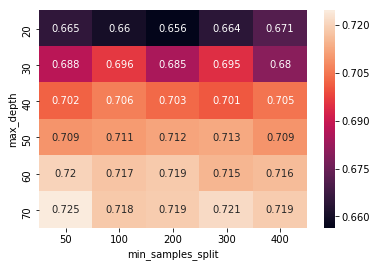

The best tuned Model:
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=70, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Tuning n_estimators 
Final Model:
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=70, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
Train Score  0.7607525600221945
Test Score   0.7939363456429747


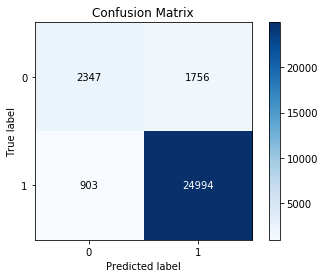

In [0]:
rf_bow_model=random_forest(std_bow_train_data,labels_train,std_bow_test_data,labels_test,'BOW')

Observation(s):


1.  From the heatmap, it can be observed that score has imporved with increase in max_depth
2.  The score has imporved with increase in n-estimators



Word Cloud of important features


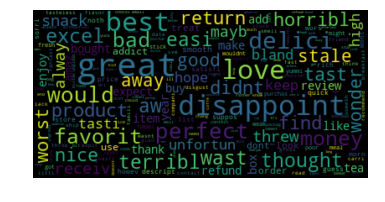

In [0]:
feature_importance(rf_bow_model,count_vect)

Observation(s):
The words 'great', 'love', 'disappoint', 'best', 'perfect', 'favorit', 'delici', 'terribl' have high feature importance. 

# Gradient Boosted Decision Trees with BOW

Tuning for learning rate and max depth 


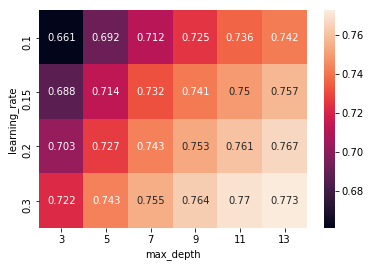

The best tuned Model:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=13, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=0.13209988355544056,
       seed=None, silent=True, subsample=1)
Tuning for N_estimators 
Model
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=13, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=0.13209988355544056,
       seed=None, silent=True, subsample=1)
Train Score 0.7933382930202019
Test Score   0.820363986456402


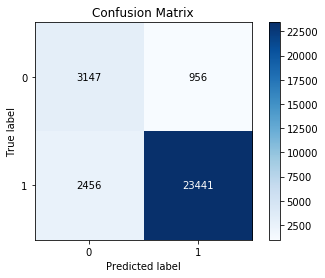

In [0]:
bow_gbdt_model=gbdt(std_bow_train_data,labels_train,std_bow_test_data,labels_test,'BOW')

Observation(s):

In the heatmap, the score increased with increase in learning rate and max_depth.

Word Cloud of important features


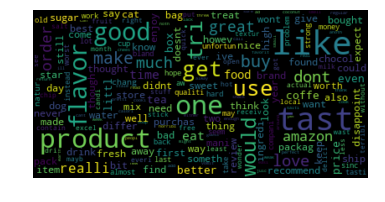

In [0]:
feature_importance(bow_gbdt_model,count_vect)

Observation(s):
The words 'like', 'tast', 'product', 'one', 'flavor', 'good', 'use' have high feature importance. 

# [7.2.5] TF-IDF

In [0]:

tf_idf_vect = TfidfVectorizer()
tf_idf_vect.fit(train_data['CleanedText'].values)
tf_idf_train_data = tf_idf_vect.transform(train_data['CleanedText'].values)
tf_idf_test_data = tf_idf_vect.transform(test_data['CleanedText'].values)


In [0]:
stdscalar= StandardScaler(with_mean = False)
stdscalar.fit(tf_idf_train_data)
std_tfidf_train_data = stdscalar.transform(tf_idf_train_data)
std_tfidf_test_data = stdscalar.transform(tf_idf_test_data)
print(std_tfidf_train_data.shape)
print(std_tfidf_test_data.shape)


(70000, 31373)
(30000, 31373)


# Random Forest with TF-IDF

Tuning for max depth and min samples split 


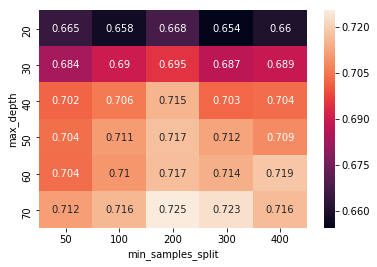

The best tuned Model:
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=70, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Tuning n_estimators 
Final Model:
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=70, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
Train Score  0.7835847307533591
Test Score   0.8109205226433035


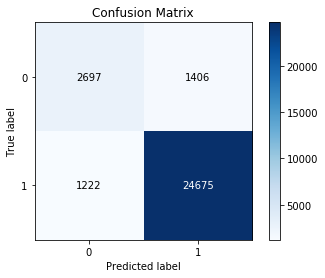

In [0]:
tfidf_rf_model=random_forest(std_tfidf_train_data,labels_train,std_tfidf_test_data,labels_test,'TF-IDF')

Observation(s):


1.  Similar to BOW, in TFIDF also, it can be observed from the heatmap that score has imporved with increase in max_depth. Also, score has imporved with increase in n-estimators

Word Cloud of important features


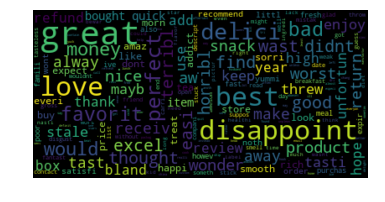

In [0]:
feature_importance(tfidf_rf_model,tf_idf_vect)

Observation(s):
1. The words 'great', 'love', 'disappoint', 'best', 'perfect', 'favorit', 'delici', 'horribl' have high feature importance. 
2. This wordcloud is very similar to that of BOW randomforest model

#  Gradient Boosted Decision Tree with TF-IDF

Tuning for learning rate and max depth 


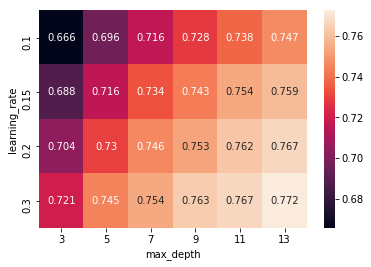

The best tuned Model:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=13, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=0.13209988355544056,
       seed=None, silent=True, subsample=1)
Tuning for N_estimators 
Model
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=13, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=0.13209988355544056,
       seed=None, silent=True, subsample=1)
Train Score 0.7849836545735854
Test Score   0.8140488697962434


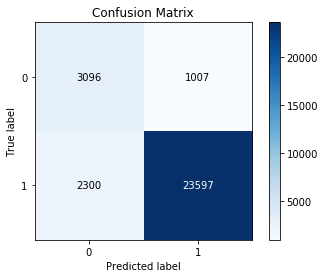

In [0]:
tfidf_gbdt_model=gbdt(std_tfidf_train_data,labels_train,std_tfidf_test_data,labels_test,'TF-IDF')

Observation(s):

The heatmap is pretty similar to that BOW model where the score increased with increase in learning rate and max_depth.

Word Cloud of important features


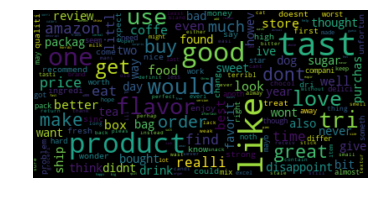

In [0]:
feature_importance(tfidf_gbdt_model,tf_idf_vect)

Observation(s):
1. The words 'like', 'tast', 'product', 'flavor', 'good', 'use', 'one', 'tri', 'love'  have high feature importance. 
2. This wordcloud is very similar to that of BOW xgboost model

# [7.2.6] Word2Vec

In [0]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle


# Train your own Word2Vec model using your own text corpus
i=0
train_list_of_sent=[]
test_list_of_sent=[]
for sent in train_data['CleanedText'].values:
    train_list_of_sent.append(sent.split())
for sent in test_data['CleanedText'].values:
    test_list_of_sent.append(sent.split())    

In [0]:
w2v_model=Word2Vec(train_list_of_sent,min_count=5,size=50, workers=4)

In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  10700
sample words  ['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirti', 'someth', 'use', 'seri', 'song', 'student', 'teach', 'preschool']


In [0]:
w2v_model.wv.most_similar('tasti')

[('delici', 0.8039253950119019),
 ('yummi', 0.7301262617111206),
 ('good', 0.6704322695732117),
 ('nice', 0.6524292230606079),
 ('hearti', 0.6351461410522461),
 ('satisfi', 0.6239311695098877),
 ('dens', 0.6052269339561462),
 ('tastey', 0.590121865272522),
 ('great', 0.5786901116371155),
 ('nutriti', 0.5713246464729309)]

In [0]:
w2v_model.wv.most_similar('like')

[('weird', 0.6905068159103394),
 ('okay', 0.6866942644119263),
 ('prefer', 0.6475175619125366),
 ('fake', 0.6358879804611206),
 ('hate', 0.6270479559898376),
 ('think', 0.616539478302002),
 ('love', 0.6026052236557007),
 ('gross', 0.6005001664161682),
 ('normal', 0.5994059443473816),
 ('funki', 0.5957318544387817)]

# [7.2.7] Avg W2V

In [0]:
# average Word2Vec
# compute average word2vec for each review.
def avgw2v(list_of_sent):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sent): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return sent_vectors

In [0]:
train_sent_vect=avgw2v(train_list_of_sent)
test_sent_vect=avgw2v(test_list_of_sent)

  0%|          | 83/30000 [00:00<00:36, 821.60it/s]

70000
50


100%|██████████| 30000/30000 [00:36<00:00, 820.57it/s]

30000
50


In [0]:
std = StandardScaler(with_mean = False)
std.fit(train_sent_vect)
std_train_vectors=std.transform(train_sent_vect)
std_test_vectors=std.transform(test_sent_vect)

# Random Forest with Avg Word2Vec

Tuning for max depth and min samples split 


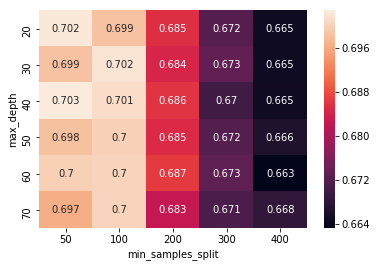

The best tuned Model:
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=40, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Tuning n_estimators 
Final Model:
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=40, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
Train Score  0.7230030702201483
Test Score   0.7437118324336499


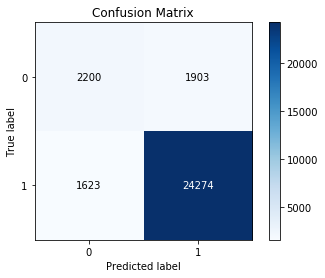

In [0]:
avgw2v_rf_model=random_forest(std_train_vectors,labels_train,std_test_vectors,labels_test,'Avg Word2Vec')

Observation(s):

1.  From the heatmap, it can be observed that the score decreased at higer values of min_samples_split.
2. Also the overall score of best model is lesser than scores of BOW,TFIDF models

# Gradient Boosted Decision Trees with Avg Word2Vec

Tuning for learning rate and max depth 


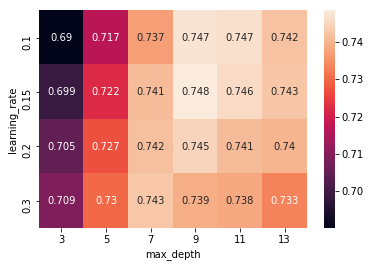

The best tuned Model:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.15, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=0.13209988355544056,
       seed=None, silent=True, subsample=1)
Tuning for N_estimators 
Model
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.15, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=0.13209988355544056,
       seed=None, silent=True, subsample=1)
Train Score 0.7484485456821883
Test Score   0.7646878041743993


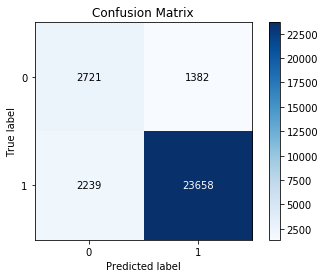

In [0]:
avgw2v_gbdt_model=gbdt(std_train_vectors,labels_train,std_test_vectors,labels_test,'Avg Word2Vec')

Observation(s):

1.  Observing the heatmap, we can say that score has increased with max_depth  initially and saturates after a particular max_depth. 

# TFIDF W2V

In [0]:
# TF-IDF weighted Word2Vec
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

def tfidf_w2v(list_of_sent,final_tf_idf):
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sent): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors    
    

    

In [0]:
w2v_tfidf_train_data=tfidf_w2v(train_list_of_sent,tf_idf_train_data)

100%|██████████| 70000/70000 [02:16<00:00, 513.90it/s]


In [0]:

w2v_tfidf_test_data=tfidf_w2v(test_list_of_sent,tf_idf_test_data)
std=StandardScaler(with_mean = False)
std.fit(w2v_tfidf_train_data)
std_w2v_tfidf_train =std.transform(w2v_tfidf_train_data)
std_w2v_tfidf_test = std.transform(w2v_tfidf_test_data)


100%|██████████| 30000/30000 [01:00<00:00, 495.80it/s]


# Random Forest with TFIDF Word2Vec

Tuning for max depth and min samples split 


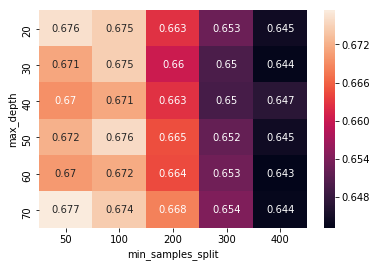

The best tuned Model:
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=70, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Tuning n_estimators 
Final Model:
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=70, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
Train Score  0.688763080909417
Test Score   0.7134608417924702


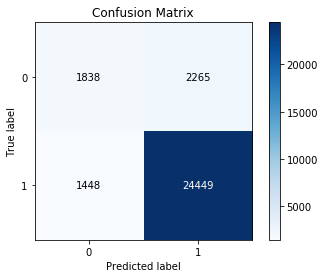

In [0]:
tfidfw2v_rf_model_2=random_forest(std_w2v_tfidf_train,labels_train,std_w2v_tfidf_test,labels_test,'TF-IDF weighted Word2Vec')

Observation(s):

1.  From the heatmap, it is evident that as min_samples_split increases , the score has decreased

# Gradient Boosted Decision Trees with TFIDF Word2Vec

Tuning for learning rate and max depth 


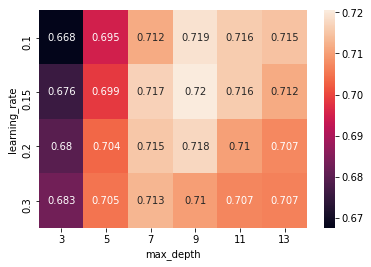

The best tuned Model:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.15, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=0.13209988355544056,
       seed=None, silent=True, subsample=1)
Tuning for N_estimators 
Model
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.15, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=0.13209988355544056,
       seed=None, silent=True, subsample=1)
Train Score 0.7204651362200655
Test Score   0.734551291485557


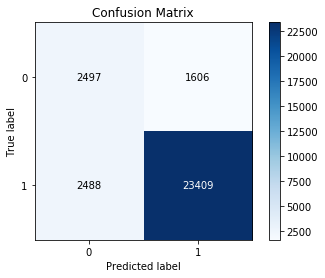

In [0]:
tfidfw2v_gbdt_model=gbdt(std_w2v_tfidf_train,labels_train,std_w2v_tfidf_test,labels_test,'TF-IDF weighted Word2Vec')

Observation(s):

1.  Observing the heatmap, similar to Avg W2V model, we can say that score has increased with max_depth  initially and saturates after a particular max_depth. 

# Conclusion

In [0]:
print(pretty_table_rf)

+--------------------------+--------------+-----------+-------------------+-------------------------+-----------------------+
|  Model - RandomForest    | n_estimators | Max Depth | Min samples split | Train Score  (f1-macro) | Test score (f1-macro) |
+--------------------------+--------------+-----------+-------------------+-------------------------+-----------------------+
|           BOW            |     500      |     70    |         50        |    0.7607525600221945   |   0.7939363456429747  |
|          TF-IDF          |     500      |     70    |        200        |    0.7835847307533591   |   0.8109205226433035  |
|       Avg Word2Vec       |     500      |     40    |         50        |    0.7230030702201483   |   0.7437118324336499  |
| TF-IDF weighted Word2Vec |     500      |     70    |         50        |    0.688763080909417    |   0.7134608417924702  |
+--------------------------+--------------+-----------+-------------------+-------------------------+-----------------

In [0]:
print(pretty_table_gbdt)

+--------------------------+--------------+------------+---------------+--------------+-------------------------+-----------------------+
|      Model - GBDT        |      CV      | max_depth  | learning_rate | n_estimators | Train Score  (f1-macro) | Test score (f1-macro) |
+--------------------------+--------------+------------+---------------+--------------+-------------------------+-----------------------+
|           BOW            | GridSearchCV |     13     |      0.3      |     500      |    0.7933382930202019   |   0.820363986456402   |
|          TF-IDF          | GridSearchCV |     13     |      0.3      |     300      |    0.7849836545735854   |   0.8140488697962434  |
|       Avg Word2Vec       | GridSearchCV |     9      |      0.15     |     100      |    0.7484485456821883   |   0.7646878041743993  |
| TF-IDF weighted Word2Vec | GridSearchCV |     9      |      0.15     |     100      |    0.7204651362200655   |   0.734551291485557   |
+--------------------------+------

Conclusion(s):

Random Forest Models:

1. The model performs better as the number of estimators increases.
2. The features  'great', 'love', 'disappoint', 'best', 'perfect', 'favorit', 'horribl', 'terribl' are important features.

XGBoost Models:

1.  The features 'like', 'tast', 'product', 'flavor', 'good', 'use', 'one', 'love'  have high feature importance. 

Random Forests VS XGBoost:

1.   The decision trees in RandomForest Classifer models are deeper with max_depth around 70 whereas decision trees of Gradient boost models have max_depth around 10. 
2.   RandomForest models need more number of estimators (500 ) to perform better. On the other side, Gradient Boosted models need lesser number of estimators than former model( less than 500).
3. Coming to Feature importance, RandomForest's important features include few critical words (disappointment,terribl,horribl etc) which isn't observed in XGBoost's important features 
4. Considering time, XGBoost models took longer duration of time to get trained than Random Forest models for the given dataset.
5.  In terms of scores, the above conclusion tables show that XGBoost models perform better than Random Forest models.

